# **6. Modelo Final**

## 6.1. Selección del Mejor Modelo
Tras evaluar distintos modelos (KNN, Árboles de Decisión, Regresión Logística, SVM, etc) se comprobó que el SVM con Kernel RBF y los hiperparámetros óptimos:
* C=10
* gamma = 'scale'
* kernel = 'rbf'

presenta el mejor desempeño en términos de Balanced Accuracy en el conjunto de validación interna. Esto lo convierte en nuestro candidato para el modelo final

## 6.2.Generación de Predicciones para la Competición
El siguiente paso es utilizar el modelo final para generar predicciones sobre el conjunto de datos de la competición. Para ello se debe aplicar el mismo preprocesado que a los datos de entrenamiento. El fichero resultante se guardará como predicciones.csv

In [ ]:
import pandas as pd
import joblib
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Importamos los datos de entrenamiento
datos_generales_originales = pd.read_csv('./attrition_availabledata_10.csv.gz')
print("Datos originales de entrenamiento cargados para ajustar el preprocesador.")


# Para el conjunto de competición, eliminamos las mismas columnas que eliminamos en el entrenamiento
datos_generales_originales['Attrition'] = datos_generales_originales['Attrition'].map({'Yes': 1, 'No': 0})
X_entrenamiento = datos_generales_originales.drop(columns=['Attrition', 'EmployeeID', 'Over18', 'EmployeeCount', 'StandardHours'])

# REDEFINIMOS MANUALMENTE EL PREPROCESADOR UTILIZADO EN EL BEST MODEL

categorical_features = ['Department', 'JobRole', 'EducationField']
ordinal_features = ['BusinessTravel', 'Gender', 'MaritalStatus']

valores_ordinales = [
    ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],   # BusinessTravel
    ['Male', 'Female'],                                     # Gender
    ['Single', 'Married', 'Divorced']                       # MaritalStatus 
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('ord', OrdinalEncoder(categories=valores_ordinales, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features)
    ],
    remainder='passthrough' 
)

# Ajustamos el preprocesador con TODOS los datos de X 
preprocessor.fit(X_entrenamiento)

# --- PASO 2: CargaMOS datos de competición y modelo final ---
datos_test_competicion = pd.read_csv('./attrition_competition_10.csv.gz')
modelo_final = joblib.load('modelo_final.pkl')


columnas_a_eliminar_test = ["EmployeeID", "EmployeeCount", "Over18", "StandardHours"]

# Asegúrate de que datos_test_competicion exista y sea el DataFrame correcto
datos_test_competicion_limpios = datos_test_competicion.drop(columns=columnas_a_eliminar_test)

# No eliminamos 'Attrition' aquí porque no existe en los datos de competición

# Aplicar el preprocesador ajustado a los datos de competición
datos_test_transformados = preprocessor.transform(datos_test_competicion_limpios)

# Convertimos a DataFrame para facilitar la manipulación
columnas_prefijadas = preprocessor.get_feature_names_out()
datos_test_listos_para_predecir = pd.DataFrame(datos_test_transformados, columns=columnas_prefijadas)

# --- PASO 3: Generamos las Predicciones ---
print("\nGenerando predicciones...")

# Pasamos el DataFrame con los nombres de columna CORRECTOS (prefijados)
y_pred_test = modelo_final.predict(datos_test_listos_para_predecir)

# Creamos un DataFrame con las predicciones y el EmployeeID original
df_predicciones = pd.DataFrame({
    'EmployeeID': datos_test_competicion['EmployeeID'], # Usamos el ID original
    'Attrition': y_pred_test # La columna de predicción
})

# Mapeamos de nuevo a 'Yes'/'No' si es necesario para el formato de salida
df_predicciones['Attrition'] = df_predicciones['Attrition'].map({1: 'Yes', 0: 'No'})

print(f"\nDistribución de predicciones:\n{df_predicciones['Attrition'].value_counts()}")

# Guardamos las predicciones
output_filename = "predicciones.csv"
df_predicciones.to_csv(output_filename, index=False)
print(f"\nPredicciones guardadas en '{output_filename}'")


Datos originales de entrenamiento cargados para ajustar el preprocesador.

Generando predicciones...

Distribución de predicciones:
Attrition
No     1236
Yes     234
Name: count, dtype: int64

Predicciones guardadas en 'predicciones.csv'


/home/alba/Documentos/INGENIERÍA INFORMATICA/3er CURSO/2ndo CUATRI/aprendizaje automático/P1_AA/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alba/Documentos/INGENIERÍA INFORMATICA/3er CURSO/2ndo CUATRI/aprendizaje automático/P1_AA/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/alba/Documentos/I

# **7. Tarea Adicional**


Para esta tarea adicional, hemos decicido utilizar la herramienta SHAP, para interpretar nuestro modelo final.

SHAP (SHapley Additive exPlanations) es una herramienta basada en la teoría de juegos que permite cuantificar la contribución de cada variable a la predicción de un modelo. Entre sus principales ventajas destacan:

* **Interpretabilidad Local y Global**: SHAP ofrece explicaciones tanto a nuvel individual (por cada predicción) como a nivel global (importancia de las variables a lo largo de todo el conjunto). Esto permite identificar cómo cada característica influye en cada decisión del modelo.

* **Consistencia y solidez**: Los valores de Shapley garantizan que la contribución de cada característica se mida de forma justa, lo que otorga una interpretación coherente y consistente.

* **Modelo-agnóstico**: A diferencia de otros métodos que se basan en la estructura interna del modelo (por ejemplo, la importancia basada en la impureza de los árboles en RandomForest), SHAP puede aplicarse a cualquier modelo.

* **Transparencia**: Integrar SHAP en el análisis del modelo permite detectar posibles sesgos o relaciones inesperadas entre variables, lo cual es fundamental para generar confianza en la toma de decisiones basadas en inteligencia artificial.

Realizar esta tarea extra con SHAP resulta especialmente interesante en comparación con construir otro modelo como un RandomForest o una red neuronal. Aunque estos modelos pueden ofrecer buenos resultados, la interpretación de sus resultados (por ejemplo, mediante la importancia de variables basada en el Gini o técnicas de regularización) suele ser menos precisa y profunda. En cambio, al interpretar el modelo SVM seleccionado con SHAP, se obtiene una explicación detallada y cuantitativa de la influencia de cada característica en la predicción, lo cual añade un valor extra al análisis, especialmente en contextos donde la explicabilidad es crucial.

## 7.1 Código para usar SHAP en nuestro modelo final

Primero, debemos instalar la libreria de shap en nuestro entorno virtual

In [4]:
!pip install shap

  0%|          | 0/10 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:00<00:00, 11.56it/s]/home/alba/Documentos/INGENIERÍA INFORMATICA/3er CURSO/2ndo CUATRI/aprendizaje automático/P1_AA/.venv/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.812e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/alba/Documentos/INGENIERÍA INFORMATICA/3er CURSO/2ndo CUATRI/aprendizaje automático/P1_AA/.venv/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.317e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
100%|██████████| 10/10 [00:00<00:00, 11.53it/s]


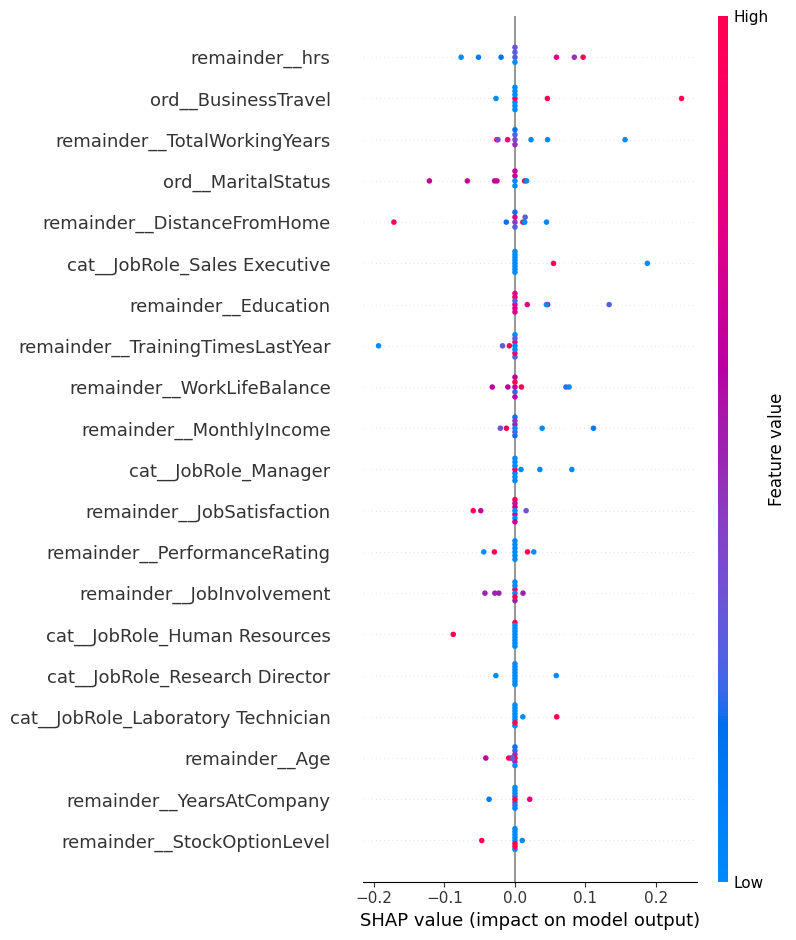

In [12]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

#Usamos el DataFrame X_entrenamiento para el preprocesamiento
X_entrenamiento_transformado_np = preprocessor.transform(X_entrenamiento) # Sale como NumPy array

columnas_preprocesadas = preprocessor.get_feature_names_out()

X_entrenamiento_preprocesado = pd.DataFrame(X_entrenamiento_transformado_np, columns=columnas_preprocesadas)

# Obtenemos los nombres de las columnas DESPUÉS del preprocesamiento

# Seleccionar una muestra representativa del conjunto preprocesado para el fondo (background)
# Reducir el tamaño del fondo para acelerar el cálculo
X_background = X_entrenamiento_preprocesado.sample(20, random_state=42)

# Definir la función de predicción asegurándonos de que se pasan los nombres de las columnas
def model_predict_proba(data):
    # KernelExplainer puede pasar un NumPy array, lo convertimos a DataFrame
    # con las columnas correctas ANTES de pasarlo al modelo.
    if not isinstance(data, pd.DataFrame):
        data_df = pd.DataFrame(data, columns=columnas_preprocesadas)
    else:
        data_df = data #
    # Accedemos al mejor estimador y usamos .predict()
    return modelo_final.best_estimator_.predict(data_df)

# Crear el explicador con KernelExplainer usando el fondo reducido
explainer = shap.KernelExplainer(model_predict_proba, X_background)

# Seleccionar un subconjunto reducido de datos para explicar
X_explain = X_entrenamiento_preprocesado.sample(10, random_state=42)

# Calcular los valores SHAP para el subconjunto seleccionado, limitando nsamples para acelerar el proceso
shap_values = explainer.shap_values(X_explain, nsamples=50)

# Visualizar el resumen de los valores SHAP para identificar la importancia de las variables
shap.summary_plot(shap_values, X_explain, feature_names=columnas_preprocesadas)
plt.show()

# Explicación local de una instancia en particular
i = 0  # índice de la instancia a explicar
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_explain.iloc[i], feature_names=columnas_preprocesadas)



Este gráfico SHAP nos muestra qué factores considera más importantes el modelo SVC al predecir la Attrition (si un empleado se va o se queda). Además, nos deja ver cómo un valor alto o bajo en cada factor afecta a empleados concretos.

El factor más decisivo aquí es *remainder__hrs*. Cuando es alto (puntos rojos en el gráfico), la probabilidad de que alguien se marche sube mucho (valores SHAP positivos). Si es bajo (puntos azules), la probabilidad disminuye (SHAP negativos).

Otros factores con bastante peso son *ord__BusinessTravel* (viajar mucho aumenta el riesgo de irse) y *remainder__TotalWorkingYears* (más años de experiencia lo reducen, con SHAP negativos). El estado civil, *ord__MaritalStatus*, también influye bastante: ser soltero (valores bajos, azules) aumenta claramente el riesgo.

El sueldo (*remainder__MonthlyIncome*) tiene un impacto muy fuerte: ganar poco (azul) hace más probable la marcha, mientras que ganar mucho (rojo) la frena bastante. Vivir lejos (*remainder__DistanceFromHome*, rojo) también parece sumar un poco a la probabilidad de irse.

En general, vemos que las condiciones laborales (hrs, BusinessTravel), el sueldo (MonthlyIncome), la experiencia (TotalWorkingYears) y la situación personal (MaritalStatus, Age) son claves para la predicción. Los patrones que vemos tienen sentido: valores altos en algunos factores empujan hacia "Sí, se va", y en otros hacia "No, se queda". Esto ayuda a entender mejor cómo piensa el modelo y a confiar en sus resultados.
